In [1]:
source('../load_environment.R')

Pivot Bio, Inc.
This code performs analyses supporting findings of the paper entitled:
"Genetic remodeling of soil diazotrophs enables partial replacement of synthetic nitrogen fertilizer with biological nitrogen fixation in maize".

##------ Thu Jun 06 10:04:28 2024 ------## 
Loaded packages:  tidyverse, readxl, broom, foreach, nlme, lme4, lmerTest, glmmTMB, car, DHARMa, caret, emmeans, multcomp, ggpubr, scales, png, ggthemes and their dependencies.
A complete list of packages used in the analysis is provided in the `packages_citations.txt` file.


## In-vitro Acetylene Reduction Assay (ARA)

In vitro experiment that measured Acetylene reduction to ethylene of seven strains:
- 2 Wildtypes (Ks6, Kv137)
- 2 NifKO (Ks6-7023, Kv137-7036)
- 3 remodeled strains ('Ks6-5687','Kv137-1036','Kv137-2253')	

The experiment was conducted in 2 N conditions:
 - N-free
 - 10 mM NH4Cl

Independed variable is  `mmol_ethylene_od`, mmol of ethylene corrected by the microbial biomass as estimated by optical density (OD)

In [2]:
iv_ara <- read_xlsx("./datasets/in_vitro_assays.xlsx", 1)
names(iv_ara) <- gsub(" |\\||/|\\(|\\)","_",tolower(names(iv_ara)))
names(iv_ara)

iv_ara <- iv_ara %>% 
mutate(
    n_source = factor(assay_n_source,labels = c("~N~free","~10~mM~NH[4]*Cl")),
    strain =paste0(ifelse(substr(strain,1,1) == 6,"Ks","Kv"),strain),
    strain_species = factor(ifelse(grepl("Ks",strain),"Kosakonia sacchari","Klebsiella variicola"), levels = c("Kosakonia sacchari","Klebsiella variicola"))) %>% 
mutate_at(c("strain","strain_species","assay_n_source","replicate"), factor)

iv_ara$strain <- factor(iv_ara$strain, levels = c('Ks6', 'Ks6-7023', 'Ks6-5687', 'Kv137', 'Kv137-7036','Kv137-1036','Kv137-2253'))
iv_ara$strain_name <- factor(iv_ara$strain, labels = c('WT (Ks6)', 'nifKO (Ks6-7023)', 'Remodeled (Ks6-5687)', 'WT (Kv137)', 'nifKO (Kv137-7036)','Remodeled Gen1 (Kv137-1036)','Remodeled Gen2 (Kv137-2253)'))
iv_ara$g <- factor(paste0(as.numeric(iv_ara$strain),as.numeric(iv_ara$n_source)))

str(iv_ara)

[1] "strain"                     "genotype"                  
 [3] "assay_n_source"             "replicate"                 
 [5] "ethylene_standard_exponent" "ethylene_standard_slope"   
 [7] "headspace_volume__l_"       "liquid_volume__ml_"        
 [9] "exposure_period__hr_"       "ending_od590"              
[11] "ethylene_area"              "mm_ethylene"               
[13] "mmol_ethylene"              "mmol_ethylene_od"          
[15] "mmol_ethylene_cfu"          "mmol_ethylene_cfu_hr"      
[17] "qc_score"                   "qc_notes"

tibble [56 x 22] (S3: tbl_df/tbl/data.frame)
 $ strain                    : Factor w/ 7 levels "Ks6","Ks6-7023",..: 3 3 3 3 2 2 2 2 1 1 ...
 $ genotype                  : chr [1:56] "<U+0394>nifL-Prm5-nifA,<U+0394>glnD,glnE-<U+0394>AR_rebuild,hp-4088_G238T,czcS-T98A" "<U+0394>nifL-Prm5-nifA,<U+0394>glnD,glnE-<U+0394>AR_rebuild,hp-4088_G238T,czcS-T98A" "<U+0394>nifL-Prm5-nifA,<U+0394>glnD,glnE-<U+0394>AR_rebuild,hp-4088_G238T,czcS-T98A" "<U+0394>nifL-Prm5-nifA,<U+0394>glnD,glnE-<U+0394>AR_rebuild,hp-4088_G238T,czcS-T98A" ...
 $ assay_n_source            : Factor w/ 2 levels "0 mM AmCl","10 mM AmCl": 2 2 2 2 2 2 2 2 2 2 ...
 $ replicate                 : Factor w/ 4 levels "A","B","C","D": 1 2 3 4 1 2 3 4 1 2 ...
 $ ethylene_standard_exponent: num [1:56] 1.12 1.12 1.12 1.12 1.12 ...
 $ ethylene_standard_slope   : num [1:56] 0.00034 0.00034 0.00034 0.00034 0.00034 ...
 $ headspace_volume__l_      : num [1:56] 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 0.007 ...
 $ liquid_volume

### First look at the data. Calculate raw treatment means.  

In [3]:
iv_ara_means <- iv_ara %>% 
group_by(g,strain_species,strain_name,strain,n_source) %>% 
summarize(n = n(), mean = mean(mmol_ethylene_od), se = sd(mmol_ethylene_od)/sqrt(n()))

iv_ara_means

`summarise()` has grouped output by 'g', 'strain_species', 'strain_name',
'strain'. You can override using the `.groups` argument.


g,strain_species,strain_name,strain,n_source,n,mean,se
<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>
11,Kosakonia sacchari,WT (Ks6),Ks6,~N~free,4,0.2308671184,0.0096683232
12,Kosakonia sacchari,WT (Ks6),Ks6,~10~mM~NH[4]*Cl,4,0.0000000000,0.0000000000
21,Kosakonia sacchari,nifKO (Ks6-7023),Ks6-7023,~N~free,4,0.0000000000,0.0000000000
22,Kosakonia sacchari,nifKO (Ks6-7023),Ks6-7023,~10~mM~NH[4]*Cl,4,0.0000000000,0.0000000000
31,Kosakonia sacchari,Remodeled (Ks6-5687),Ks6-5687,~N~free,4,0.0338059923,0.0133262157
32,Kosakonia sacchari,Remodeled (Ks6-5687),Ks6-5687,~10~mM~NH[4]*Cl,4,0.2006443592,0.0246518360
41,Klebsiella variicola,WT (Kv137),Kv137,~N~free,4,0.4817315784,0.0110316850
42,Klebsiella variicola,WT (Kv137),Kv137,~10~mM~NH[4]*Cl,4,0.0000000000,0.0000000000
51,Klebsiella variicola,nifKO (Kv137-7036),Kv137-7036,~N~free,4,0.0007602433,0.0002869494


Note that the `WT` and `nifKO` strains are there as process controls, such that we expect then to have very low or no `mmol_ethylene_od`, so we will exclude them from analysis

In [4]:
iv_ara_means %>% filter(mean > 0)

g,strain_species,strain_name,strain,n_source,n,mean,se
<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>
11,Kosakonia sacchari,WT (Ks6),Ks6,~N~free,4,0.2308671184,0.0096683232
31,Kosakonia sacchari,Remodeled (Ks6-5687),Ks6-5687,~N~free,4,0.0338059923,0.0133262157
32,Kosakonia sacchari,Remodeled (Ks6-5687),Ks6-5687,~10~mM~NH[4]*Cl,4,0.2006443592,0.0246518360
41,Klebsiella variicola,WT (Kv137),Kv137,~N~free,4,0.4817315784,0.0110316850
51,Klebsiella variicola,nifKO (Kv137-7036),Kv137-7036,~N~free,4,0.0007602433,0.0002869494
61,Klebsiella variicola,Remodeled Gen1 (Kv137-1036),Kv137-1036,~N~free,4,0.6166993240,0.0096918487
62,Klebsiella variicola,Remodeled Gen1 (Kv137-1036),Kv137-1036,~10~mM~NH[4]*Cl,4,0.1354701468,0.0071982585
71,Klebsiella variicola,Remodeled Gen2 (Kv137-2253),Kv137-2253,~N~free,4,0.9259656874,0.1724717367
72,Klebsiella variicola,Remodeled Gen2 (Kv137-2253),Kv137-2253,~10~mM~NH[4]*Cl,4,0.3025567014,0.1016077430


## Analysis for Kosakonia sacchari
### We check assumption of equal variances

In [5]:
iv_ara_ks <- filter(iv_ara, strain %in% c("Ks6","Ks6-5687"), !(strain == "Ks6"  & assay_n_source == "10 mM AmCl")) 

In [6]:
iv_ara_ks %>% 
leveneTest(mmol_ethylene_od ~ g, data = .)



,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,0.6510237,0.5444216
,9,NA,NA


Some evidence that variances are unequal across treatments 

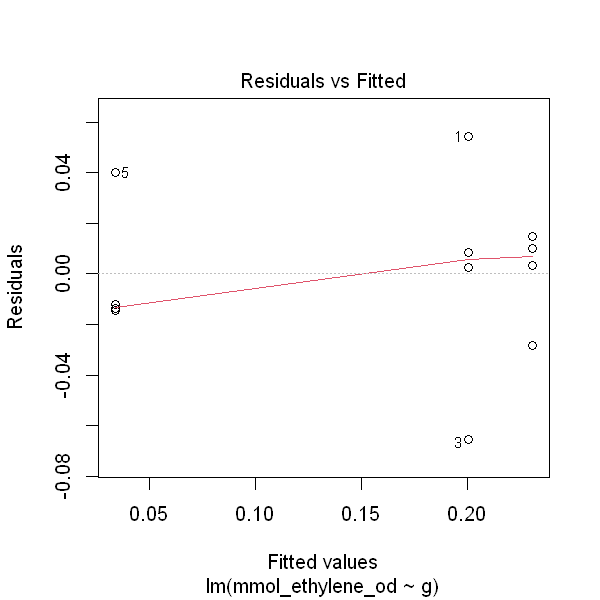

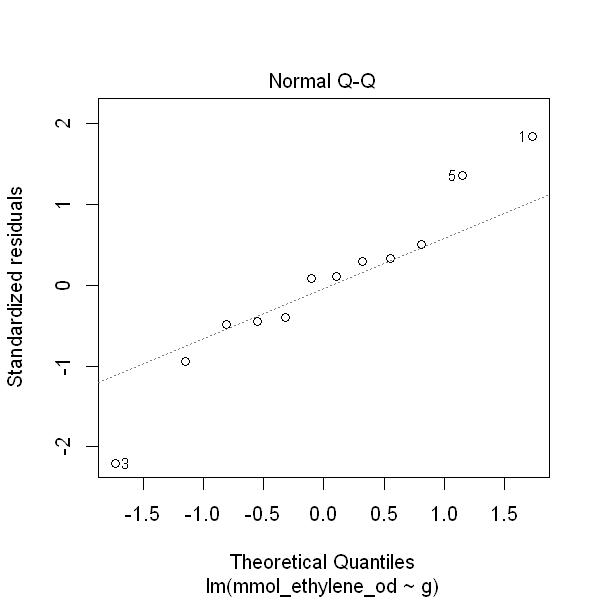

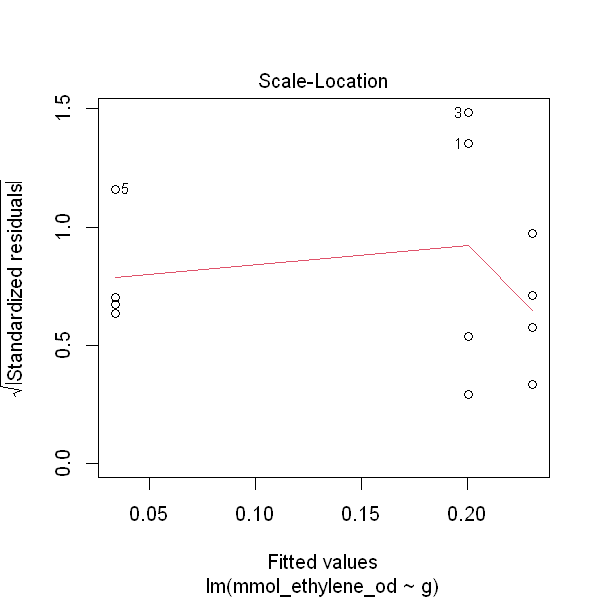

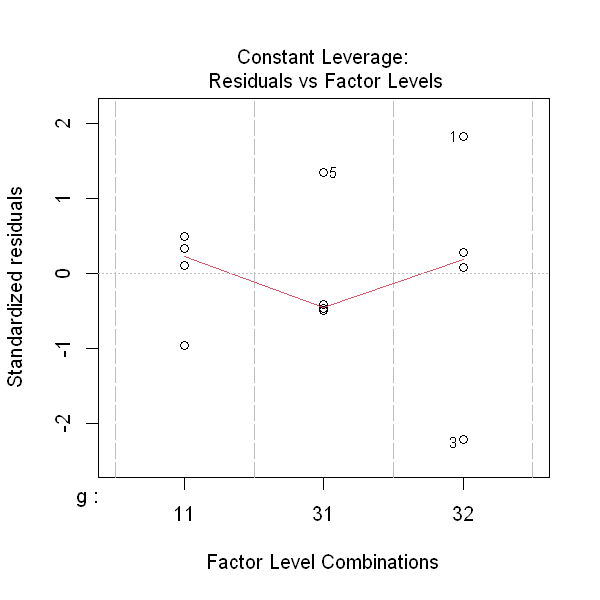

In [7]:
iv_ara_ks_mod <- lm(mmol_ethylene_od ~ g, iv_ara_ks)
plot(iv_ara_ks_mod)

In [8]:
summary(iv_ara_ks_mod)


Call:
lm(formula = mmol_ethylene_od ~ g, data = iv_ara_ks)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.065351 -0.013759  0.002908  0.011143  0.054237 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.23087    0.01712  13.489 2.83e-07 ***
g31         -0.19706    0.02420  -8.142 1.92e-05 ***
g32         -0.03022    0.02420  -1.249    0.243    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03423 on 9 degrees of freedom
Multiple R-squared:  0.8952,	Adjusted R-squared:  0.872 
F-statistic: 38.45 on 2 and 9 DF,  p-value: 3.9e-05


### Calulate LS means and mean-separation

In [9]:
iv_ara_ks_emm <- emmeans(iv_ara_ks_mod, ~ g, adjust = "tukey", type = "response") %>% 
cld(Letters = letters) %>%
left_join(
    iv_ara %>% 
    group_by(g,strain,strain_name,strain_species,assay_n_source,n_source) %>% 
    ### A helper varaible to help position the letters in the plot
    summarize(y = mean(mmol_ethylene_od) + sd(mmol_ethylene_od)/sqrt(n()))) 

iv_ara_ks_emm

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

`summarise()` has grouped output by 'g', 'strain', 'strain_name',
'strain_species', 'assay_n_source'. You can override using the `.groups`
argument.
Joining with `by = join_by(g)`


g,emmean,SE,df,lower.CL,upper.CL,.group,strain,strain_name,strain_species,assay_n_source,n_source,y
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
31,0.03380599,0.01711508,9,-0.01621918,0.08383117,a,Ks6-5687,Remodeled (Ks6-5687),Kosakonia sacchari,0 mM AmCl,~N~free,0.04713221
32,0.20064436,0.01711508,9,0.15061918,0.25066954,b,Ks6-5687,Remodeled (Ks6-5687),Kosakonia sacchari,10 mM AmCl,~10~mM~NH[4]*Cl,0.22529620
11,0.23086712,0.01711508,9,0.18084194,0.28089229,b,Ks6,WT (Ks6),Kosakonia sacchari,0 mM AmCl,~N~free,0.24053544


## Analysis for Klebsiella variicola

In [10]:
iv_ara_kv <- filter(iv_ara, strain %in% c('Kv137','Kv137-1036','Kv137-2253'), !(strain == "Kv137"  & assay_n_source == "10 mM AmCl")) 

In [11]:
### We check assumption of equal variances

iv_ara_kv %>% 
leveneTest(mmol_ethylene_od ~ g, data = .)



,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,4,1.512569,0.2485077
,15,NA,NA


No evidence that variances are unequal across treatments 

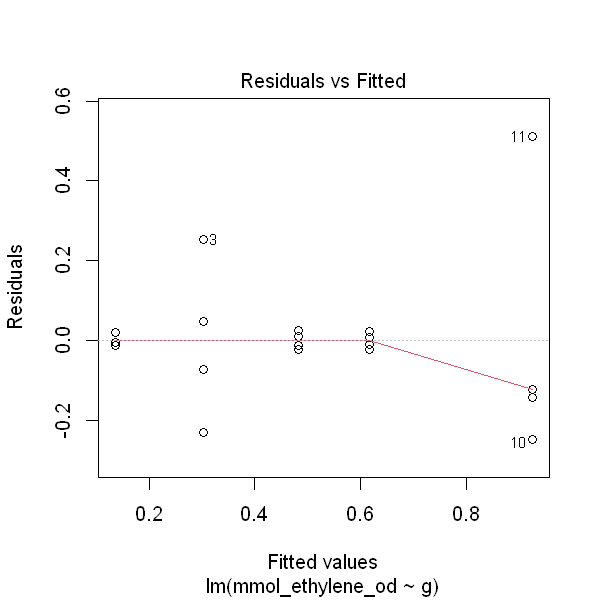

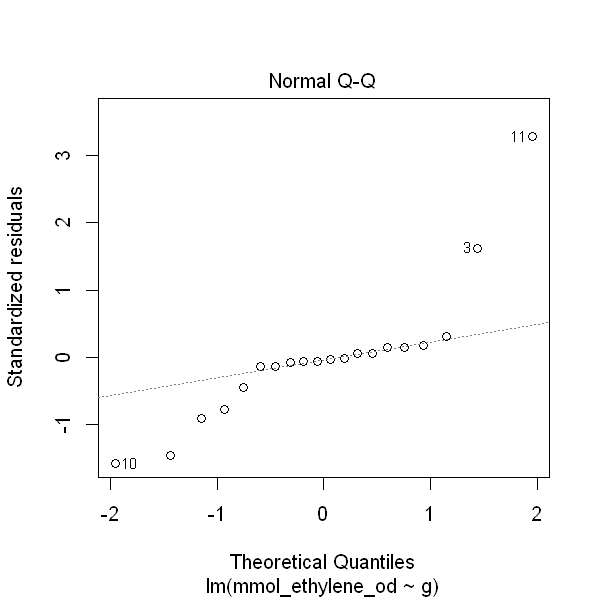

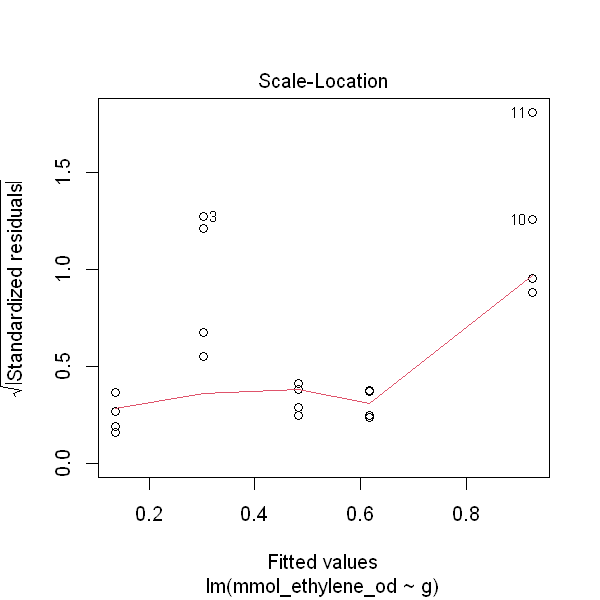

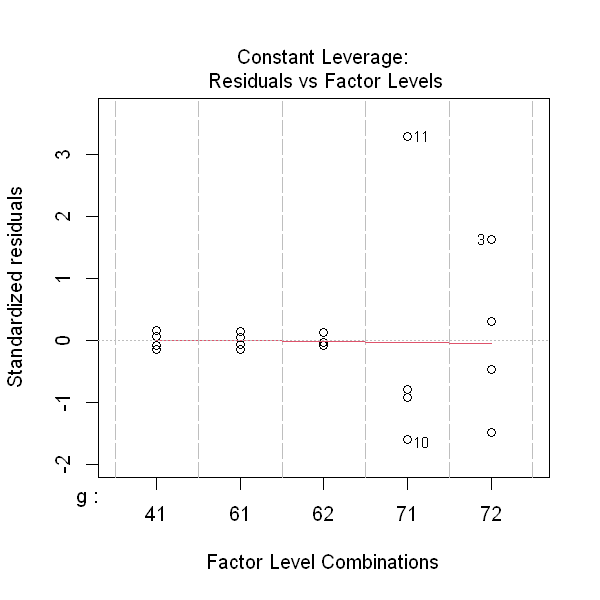

In [12]:
iv_ara_kv_mod <- lm(mmol_ethylene_od ~ g, iv_ara_kv)
plot(iv_ara_kv_mod)

In [13]:
summary(iv_ara_kv_mod)


Call:
lm(formula = mmol_ethylene_od ~ g, data = iv_ara_kv)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.24710 -0.03471 -0.00764  0.02136  0.51079 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.48173    0.08982   5.363  7.9e-05 ***
g61          0.13497    0.12702   1.063  0.30480    
g62         -0.34626    0.12702  -2.726  0.01562 *  
g71          0.44423    0.12702   3.497  0.00324 ** 
g72         -0.17917    0.12702  -1.411  0.17878    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1796 on 15 degrees of freedom
Multiple R-squared:  0.752,	Adjusted R-squared:  0.6859 
F-statistic: 11.37 on 4 and 15 DF,  p-value: 0.0001907


### Calulate LS means and mean-separation

In [14]:
iv_ara_kv_emm <- emmeans(iv_ara_kv_mod, ~ g, adjust = "tukey", type = "response") %>% 
cld(Letters = letters) %>%
left_join(
    iv_ara %>% 
    group_by(g,strain,strain_name,strain_species,assay_n_source,n_source) %>% 
    ### A helper varaible to help position the letters in the plot
    summarize(y = mean(mmol_ethylene_od) + sd(mmol_ethylene_od)/sqrt(n()))) 

iv_ara_kv_emm

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons

`summarise()` has grouped output by 'g', 'strain', 'strain_name',
'strain_species', 'assay_n_source'. You can override using the `.groups`
argument.
Joining with `by = join_by(g)`


g,emmean,SE,df,lower.CL,upper.CL,.group,strain,strain_name,strain_species,assay_n_source,n_source,y
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
62,0.1354701,0.08981991,15,-0.12830088,0.3992412,a,Kv137-1036,Remodeled Gen1 (Kv137-1036),Klebsiella variicola,10 mM AmCl,~10~mM~NH[4]*Cl,0.1426684
72,0.3025567,0.08981991,15,0.03878568,0.5663277,ab,Kv137-2253,Remodeled Gen2 (Kv137-2253),Klebsiella variicola,10 mM AmCl,~10~mM~NH[4]*Cl,0.4041644
41,0.4817316,0.08981991,15,0.21796055,0.7455026,ab,Kv137,WT (Kv137),Klebsiella variicola,0 mM AmCl,~N~free,0.4927633
61,0.6166993,0.08981991,15,0.35292830,0.8804703,bc,Kv137-1036,Remodeled Gen1 (Kv137-1036),Klebsiella variicola,0 mM AmCl,~N~free,0.6263912
71,0.9259657,0.08981991,15,0.66219466,1.1897367,c,Kv137-2253,Remodeled Gen2 (Kv137-2253),Klebsiella variicola,0 mM AmCl,~N~free,1.0984374


### ARA plot

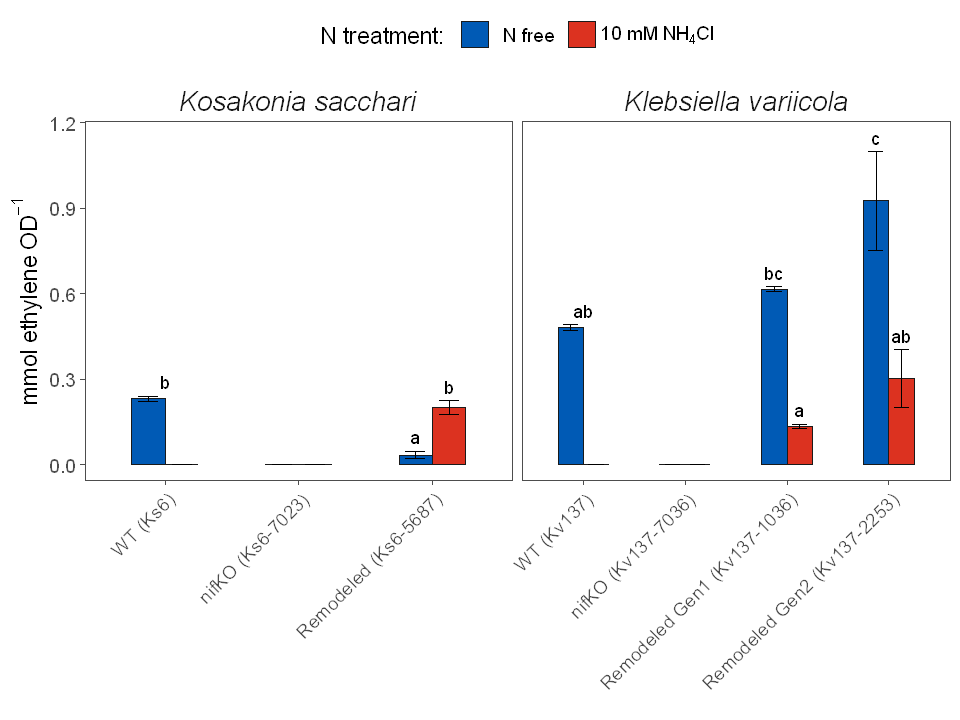

In [15]:
options(repr.plot.width=8, repr.plot.height=6)

iv_ara_plot <- iv_ara_means %>% 
ggplot(aes(strain_name, mean, fill = n_source)) + 
geom_col(colour = "gray10", position = position_dodge(), width = 0.5) + 
geom_errorbar(aes(ymin = mean - se, ymax = mean + se), position = position_dodge(width = 0.5), width = 0.3) + 
facet_wrap(~strain_species, scales= "free_x" ) + 
geom_text(aes(y = y + 0.05, label = gsub(" ","",.group)), data = bind_rows(iv_ara_kv_emm,iv_ara_ks_emm), position = position_dodge(width = 0.5))  + 
scale_fill_manual(values = myColorPalette,labels = parse_format()) +
theme(legend.position = "top", axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), strip.text = element_text(size = 16, face = "italic") ) + 
labs(y = expression("mmol ethylene"~~OD^-1), x = "", fill = "N treatment:")

iv_ara_plot

## In-vitro Ammonium excretion assay (AMM)

In vitro experiment that measured excretion of NH4 by seven strains:
- 2 Wildtypes (Ks6, Kv137)
- 2 NifKO (Ks6-7023, Kv137-7036)
- 3 remodeled strains ('Ks6-5687','Kv137-1036','Kv137-2253')	

The experiment was conducted in N-free conditions

Independed variable is  `nh4_od_mm_od`, mmol of NH4 corrected by the microbial biomass as estimated by optical density (OD)


In [16]:
iv_amm <- read_xlsx("./datasets/in_vitro_assays.xlsx", 2)

names(iv_amm)

# Clean names
names(iv_amm) <- gsub(" |[[:punct:]]","_",tolower(names(iv_amm)))
names(iv_amm) <- gsub("_{2,}","_",names(iv_amm))
names(iv_amm) <- gsub("^_|_$","",names(iv_amm))

names(iv_amm)


iv_amm <- iv_amm %>% 
mutate(strain =paste0(ifelse(substr(strain,1,1) == 6,"Ks","Kv"),strain),
strain_species = factor(ifelse(grepl("Ks",strain),"Kosakonia sacchari","Klebsiella variicola"), levels = c("Kosakonia sacchari","Klebsiella variicola"))) %>%
mutate_at(c("strain","strain_species","replicate"), factor) 

iv_amm$strain <- factor(iv_amm$strain, levels = c('Ks6', 'Ks6-7023', 'Ks6-5687', 'Kv137', 'Kv137-7036','Kv137-1036','Kv137-2253'))
iv_amm$strain_name <- factor(iv_amm$strain, labels = c('WT (Ks6)', 'nifKO (Ks6-7023)', 'Remodeled (Ks6-5687)', 'WT (Kv137)', 'nifKO (Kv137-7036)','Remodeled Gen1 (Kv137-1036)','Remodeled Gen2 (Kv137-2253)'))

#head(iv_amm)


[1] "Strain"                  "Assay ID"               
 [3] "Sample ID"               "Parent"                 
 [5] "Genotype"                "Replicate"              
 [7] "Starting OD590"          "Ending OD590"           
 [9] "[NH4+] (mM)"             "[NH4+]/OD (mM/OD)"      
[11] "Duration (Hours)"        "[NH4+]/OD'hr (mM/OD'hr)"

[1] "strain"             "assay_id"           "sample_id"         
 [4] "parent"             "genotype"           "replicate"         
 [7] "starting_od590"     "ending_od590"       "nh4_mm"            
[10] "nh4_od_mm_od"       "duration_hours"     "nh4_od_hr_mm_od_hr"

### Calcualte raw means

In [17]:
iv_amm_means <- iv_amm %>% 
group_by(strain_species,strain_name,strain) %>% 
summarize(n = n(), mean = mean(nh4_od_mm_od), se = sd(nh4_od_mm_od)/sqrt(n()))

iv_amm_means

`summarise()` has grouped output by 'strain_species', 'strain_name'. You can
override using the `.groups` argument.


strain_species,strain_name,strain,n,mean,se
<fct>,<fct>,<fct>,<int>,<dbl>,<dbl>
Kosakonia sacchari,WT (Ks6),Ks6,8,0.007689876,0.0014020441
Kosakonia sacchari,nifKO (Ks6-7023),Ks6-7023,8,0.030388200,0.0032489794
Kosakonia sacchari,Remodeled (Ks6-5687),Ks6-5687,8,7.552213548,0.9142322257
Klebsiella variicola,WT (Kv137),Kv137,8,0.018462379,0.0013409907
Klebsiella variicola,nifKO (Kv137-7036),Kv137-7036,8,-0.005232912,0.0008786032
Klebsiella variicola,Remodeled Gen1 (Kv137-1036),Kv137-1036,8,0.462832346,0.0573440242
Klebsiella variicola,Remodeled Gen2 (Kv137-2253),Kv137-2253,8,7.049436881,1.0867666889


Very obvious that edits increased NH4 excretion. However, we are interested in estimating the improvement between Gen1 and Gen2 edits. These appears to be several orders of magnitude, so we use log transformed units.

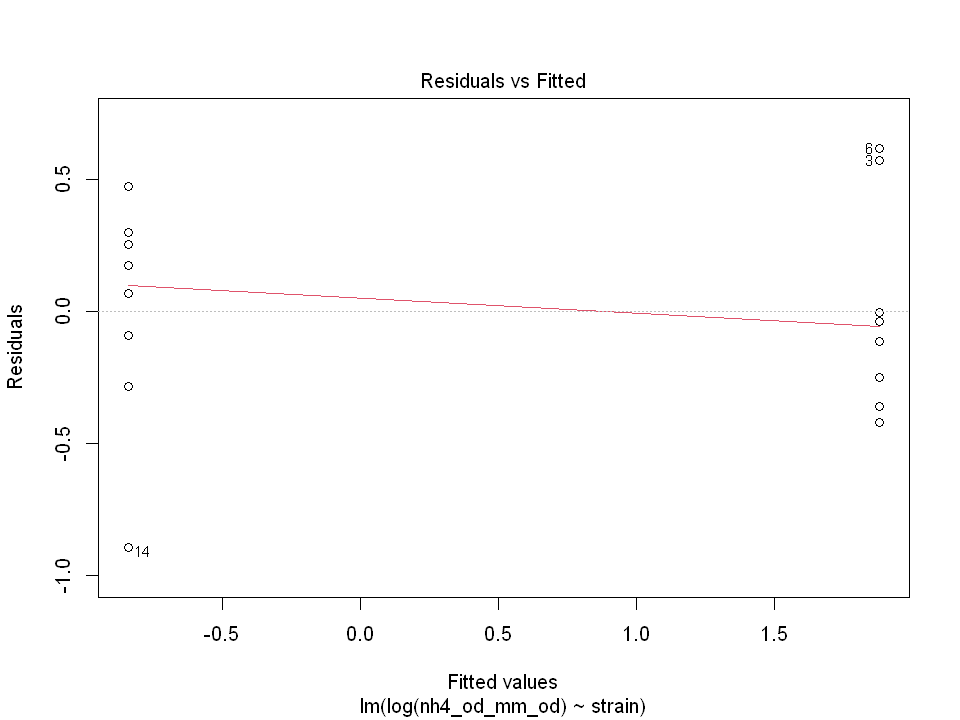

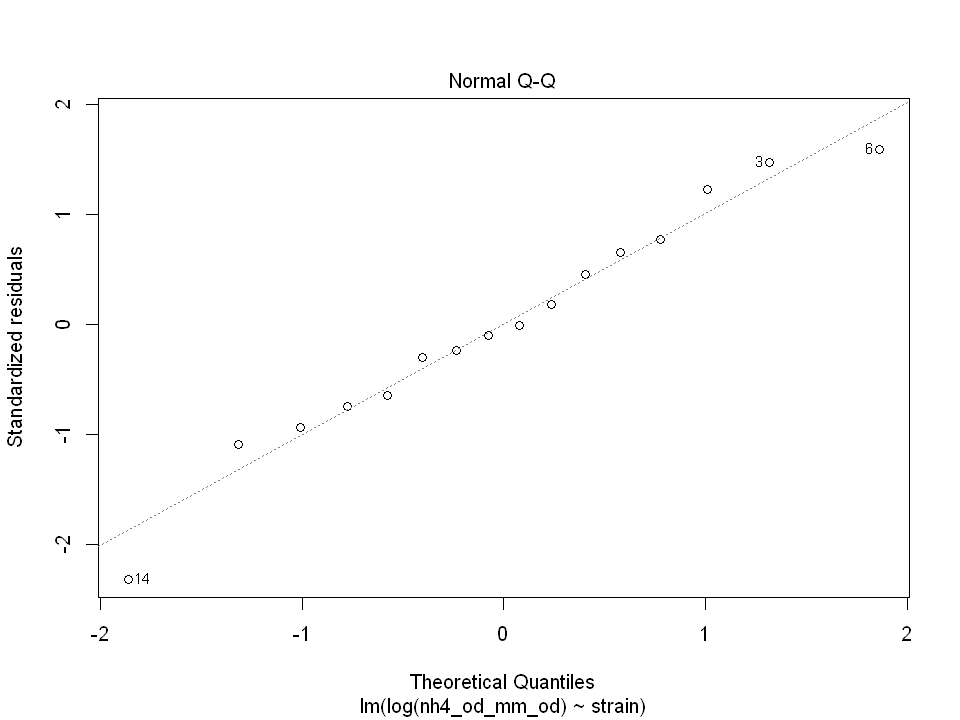

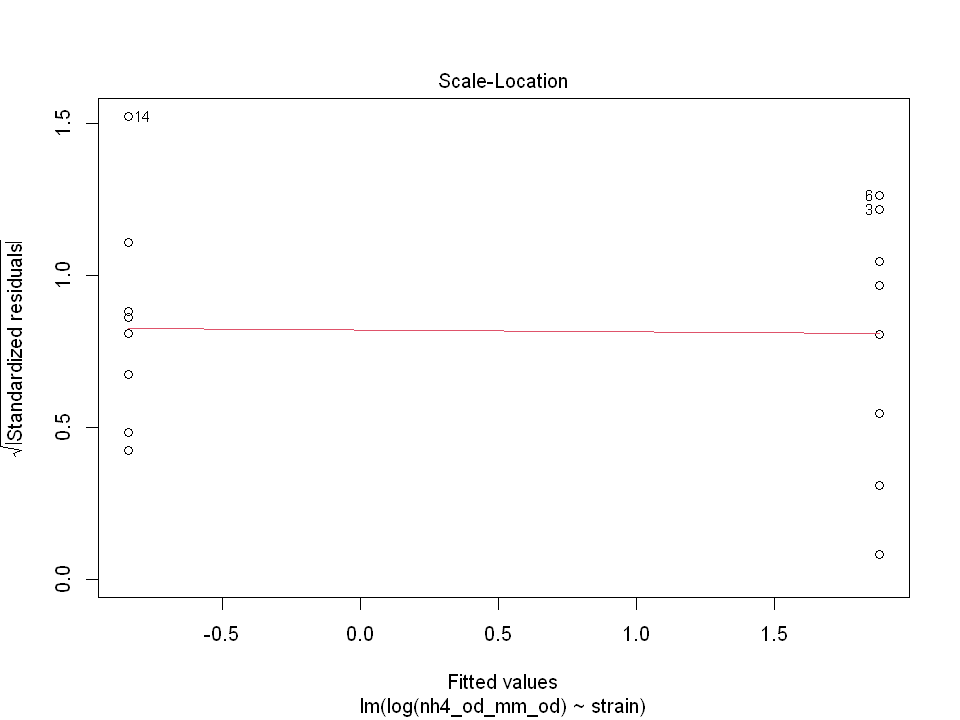

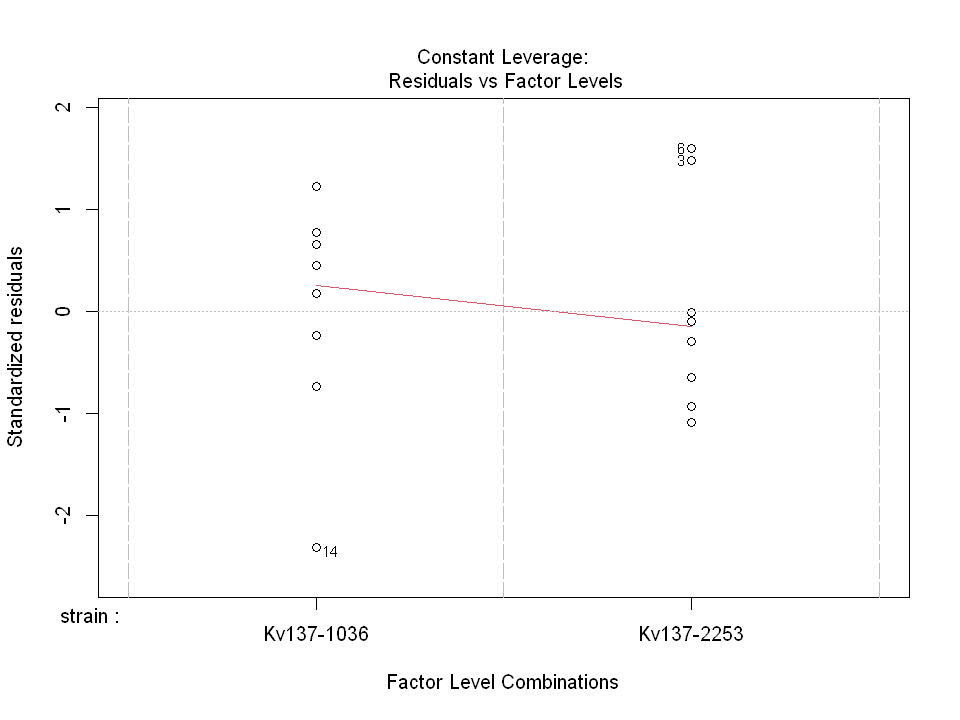

In [18]:
iv_amm_mod <- lm(log(nh4_od_mm_od) ~ strain, iv_amm %>% filter(strain %in% c("Kv137-2253","Kv137-1036")))
plot(iv_amm_mod)

In [19]:
summary(iv_amm_mod)


Call:
lm(formula = log(nh4_od_mm_od) ~ strain, data = iv_amm %>% filter(strain %in% 
    c("Kv137-2253", "Kv137-1036")))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.89258 -0.25918 -0.01951  0.26358  0.61534 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -0.8402     0.1460  -5.755 4.98e-05 ***
strainKv137-2253   2.7203     0.2065  13.175 2.80e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.413 on 14 degrees of freedom
Multiple R-squared:  0.9254,	Adjusted R-squared:   0.92 
F-statistic: 173.6 on 1 and 14 DF,  p-value: 2.795e-09


In [20]:
iv_amm_mod_coef <- data.frame(summary(iv_amm_mod)$coefficients)
iv_amm_mod_coef

,Estimate,Std..Error,t.value,Pr...t..
,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.8401967,0.1460002,-5.754764,4.982492e-05
strainKv137-2253,2.7203130,0.2064755,13.174993,2.795042e-09


In [21]:
# Get the estimated change
exp(iv_amm_mod_coef["strainKv137-2253","Estimate"])

[1] 15.18507

In [22]:
# Make a nice label for plotting

lab <- paste0(
    signif(exp(iv_amm_mod_coef["strainKv137-2253","Estimate"]),3),"x (±",
    signif(exp(iv_amm_mod_coef["strainKv137-2253","Std..Error"]),3),"x)\n",
    ifelse(iv_amm_mod_coef["strainKv137-2253","Pr...t.."] < 0.0001,"p < 0.0001",paste0("p =",signif(iv_amm_mod_coef["strainKv137-2253","Pr...t.."],3)))
    )

lab

[1] "15.2x (±1.23x)\np < 0.0001"

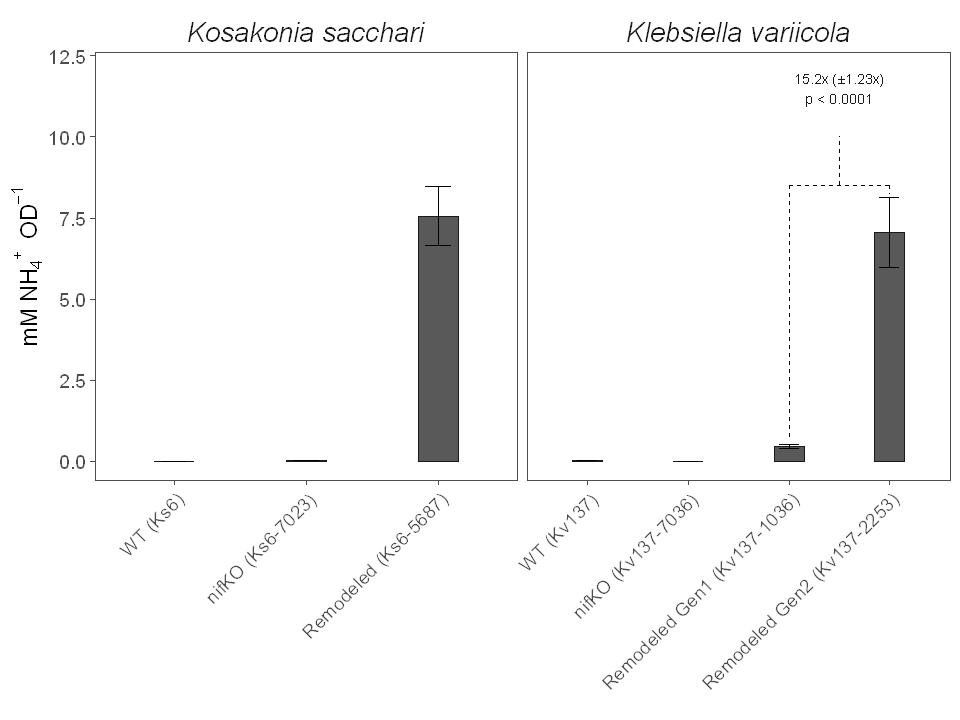

In [23]:
options(repr.plot.width=8, repr.plot.height=6)
label_y_pos <- 12

iv_amm_plot <- iv_amm_means %>% 
ggplot(aes(strain_name, mean)) + 
geom_col(colour = "gray10", position = position_dodge(), width = 0.3) + 
geom_errorbar(aes(ymin = mean - se, ymax = mean + se), position = position_dodge(width = 0.3), width = 0.2) + 
facet_wrap(~strain_species, scales= "free_x" ) + 
geom_segment(aes(xend =  strain_name, y = label_y_pos - 3.5, yend = mean + se + 0.1), linetype = 2, data = iv_amm_means %>% filter(strain %in% c("Kv137-2253","Kv137-1036"))) + 
geom_segment(aes(x = 3.5, xend =  3.5, y = label_y_pos - 3.5, yend = label_y_pos - 2), linetype = 2, data = data.frame(strain_species = factor("Klebsiella variicola",levels = c("Klebsiella variicola","Kosakonia sacchari")))) + 
geom_segment(aes(x = 3, xend =  4, y = label_y_pos - 3.5, yend = label_y_pos - 3.5), linetype = 2, data = data.frame(strain_species = factor("Klebsiella variicola",levels = c("Klebsiella variicola","Kosakonia sacchari")))) + 
geom_text(aes(x = 3.5,y = label_y_pos, label = lab), colour = "gray10", vjust = 1, size = 3, data = data.frame(lab = lab, strain_species = factor("Klebsiella variicola",levels = c("Klebsiella variicola","Kosakonia sacchari")))) + 
theme(legend.position = "top", axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), strip.text = element_text(size = 16, face = "italic") ) + 
labs(y = expression("mM NH"[4]*""^"+"~~OD^-1), x = "")

iv_amm_plot

### Make final graphic for the paper

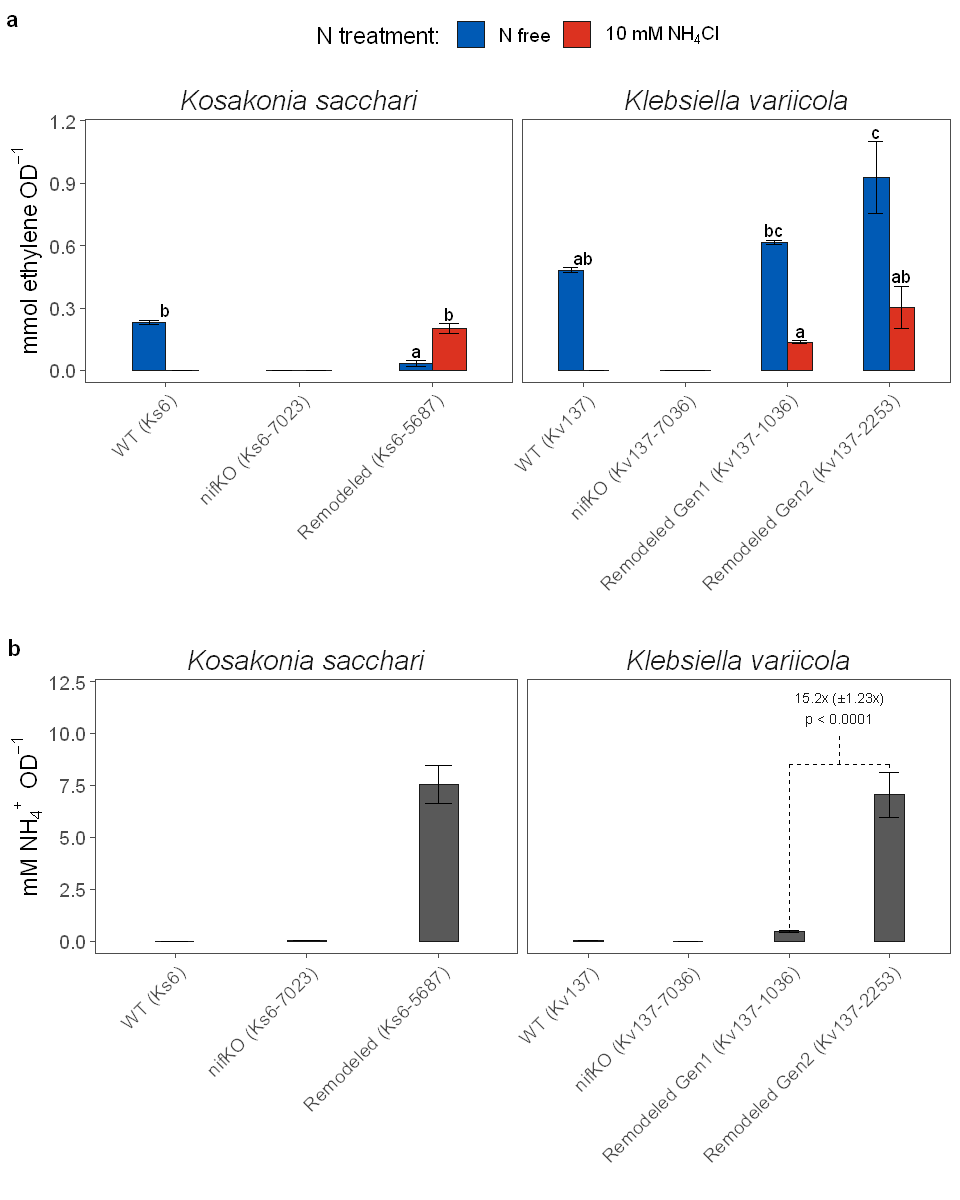

In [24]:
options(repr.plot.width=8, repr.plot.height=10)

ggarrange(iv_ara_plot,iv_amm_plot, nrow = 2, heights = c(0.55,0.5), labels = c("a","b"))

In [25]:
ggsave("./figures/in_vitro_assays.png",width = 8, height = 10, dpi = 300)